## Inprocessing - Prejudice Remover -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_adult_race, load_adult_sex
from src.modeling import prejudice_remover_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, best_hyperparameter_advdeb
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/adult_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/adult_sex_metrics_agg.csv', index_col=0)

--------------------------------------------------------------------------------------------------------------------------------------

## default prejudice remover, sex

In [3]:
# 1) Load data
protected          = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_sex()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    eta=25.0
    )
        
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
adult_sex_metrics     = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])
print(adult_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.850359  0.655819 -0.181099  0.291650 -0.115286 -0.097235
std   0.002544  0.005260  0.006630  0.017324  0.021877  0.012188


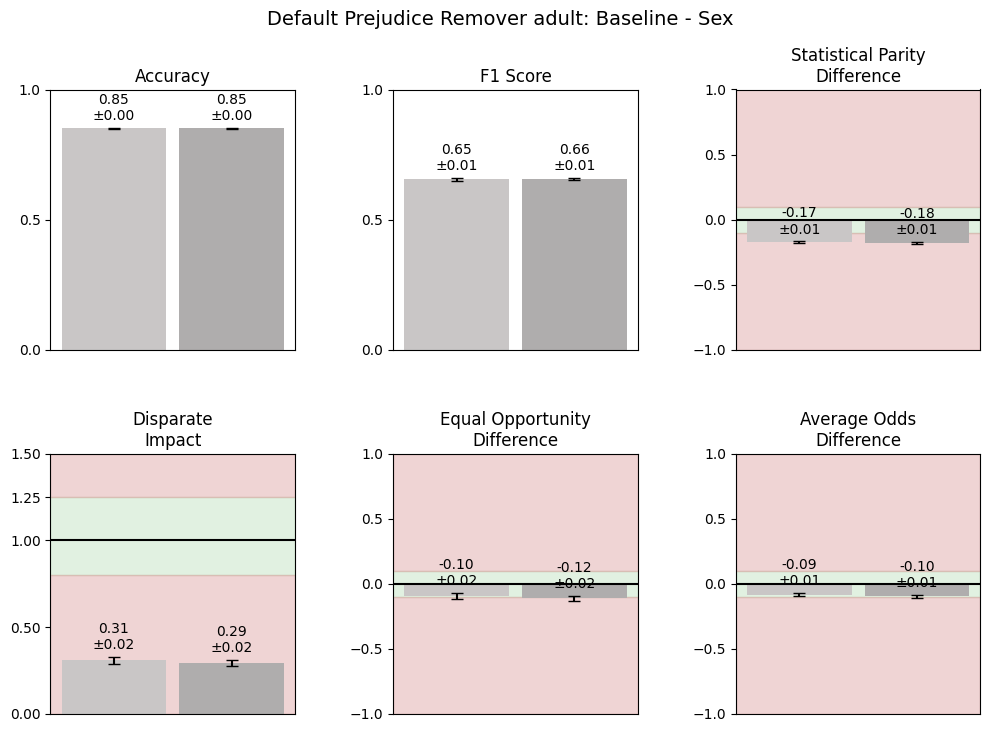

In [4]:
compare_viz_metrics_2x3(baseline_sex_agg, adult_sex_metrics_agg, 'Baseline', 'Sex', 'Default Prejudice Remover adult: Baseline - Sex')

## default prejudice remover, race

In [5]:
# 1) Load data
protected          = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
    df, train_idx, test_idx,
    protected, privileged_value, unprivileged_value,
    eta=25.0
    ) 
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
adult_race_metrics     = pd.DataFrame(results)
adult_race_metrics_agg = adult_race_metrics.agg(['mean', 'std'])
print(adult_race_metrics_agg)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.850380  0.655922 -0.092051  0.559215 -0.072235 -0.052487
std   0.002732  0.005474  0.006309  0.029009  0.023690  0.012163


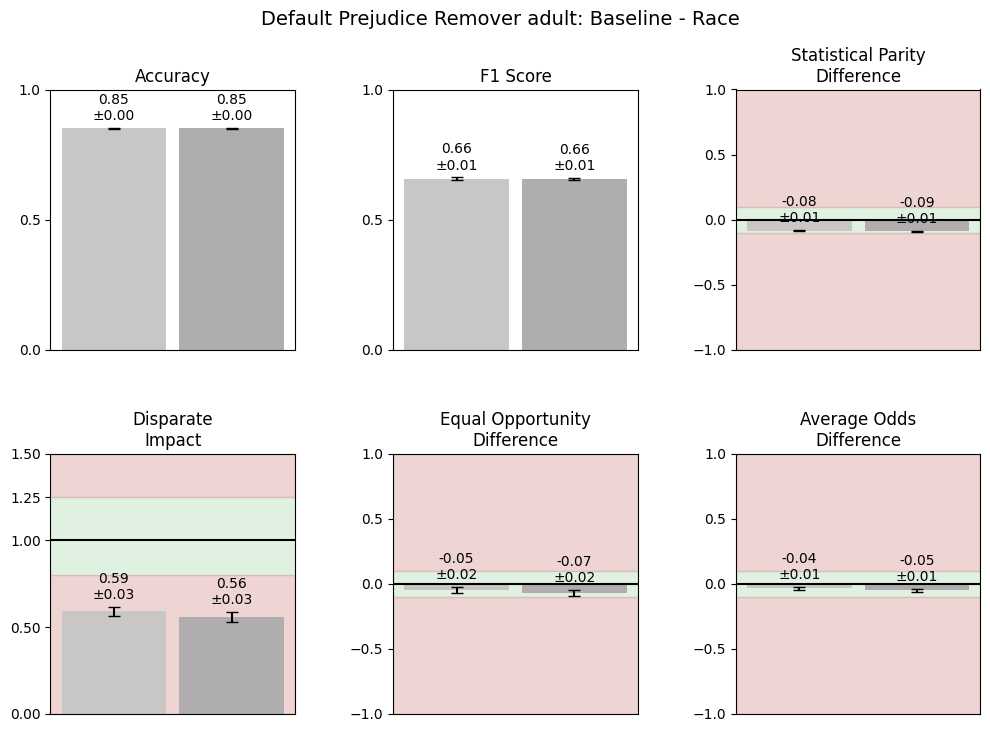

In [6]:
compare_viz_metrics_2x3(baseline_race_agg, adult_race_metrics_agg, 'Baseline', 'Race', 'Default Prejudice Remover adult: Baseline - Race')

## hyperparameter search adversial debiaser, race

In [7]:
# 1) Load data
protected          = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_race()
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Sweep η grid
eta_grid = [15.0, 25.0, 40.0, 60.0]
grid_results = []
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

for eta in eta_grid:
    fold_metrics = []
    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = prejudice_remover_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            eta=eta
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)

    agg = pd.DataFrame(fold_metrics).agg(['mean','std'])
    grid_results.append({
        'eta':      eta,
        'acc_mean': agg.loc['mean','accuracy'],
        'SPD_mean': agg.loc['mean','SPD'],
        'DI_mean':  agg.loc['mean','DI'],
        # add other metrics as needed...
    })

results_df = pd.DataFrame(grid_results)

# 3) Pick best
best_row = best_hyperparameter_advdeb(results_df)
chosen_eta = best_row['eta']
print(f"Chosen eta: {chosen_eta}")

# 4) Final evaluation with PrejudiceRemover
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        eta=chosen_eta
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate 
adult_race_metrics     = pd.DataFrame(final_metrics)
adult_race_metrics_agg = adult_race_metrics.agg(['mean','std'])
print(adult_race_metrics_agg)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

Chosen eta: 15.0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.850661  0.655323 -0.093422  0.552205 -0.076095 -0.054578
std   0.006891  0.017624  0.025253  0.111604  0.093323  0.047322


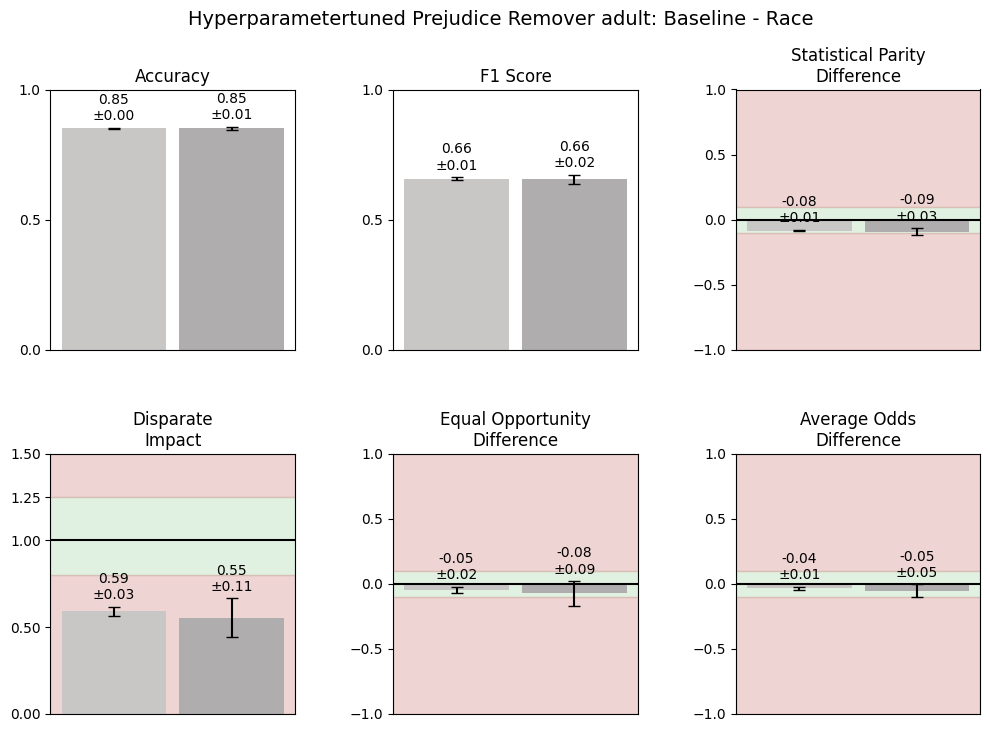

In [8]:
compare_viz_metrics_2x3(baseline_race_agg, adult_race_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Prejudice Remover adult: Baseline - Race')

## hyperparameter search adversial debiaser, race

In [9]:
# 1) Load data
protected          = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_sex()
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Sweep η grid
eta_grid = [15.0, 25.0, 40.0, 60.0]
grid_results = []
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

for eta in eta_grid:
    fold_metrics = []
    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = prejudice_remover_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            eta=eta
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)

    agg = pd.DataFrame(fold_metrics).agg(['mean','std'])
    grid_results.append({
        'eta':      eta,
        'acc_mean': agg.loc['mean','accuracy'],
        'SPD_mean': agg.loc['mean','SPD'],
        'DI_mean':  agg.loc['mean','DI'],
        # add other metrics as needed...
    })

results_df = pd.DataFrame(grid_results)

# 3) Pick best
best_row = best_hyperparameter_advdeb(results_df)
chosen_eta = best_row['eta']
print(f"Chosen eta: {chosen_eta}")

# 4) Final evaluation with PrejudiceRemover
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = prejudice_remover_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        eta=chosen_eta
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate 
adult_sex_metrics     = pd.DataFrame(final_metrics)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean','std'])
print(adult_sex_metrics_agg)


Chosen eta: 60.0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.849043  0.649127 -0.178611  0.290194 -0.108655 -0.092715
std   0.012312  0.042565  0.018383  0.050054  0.070141  0.037163


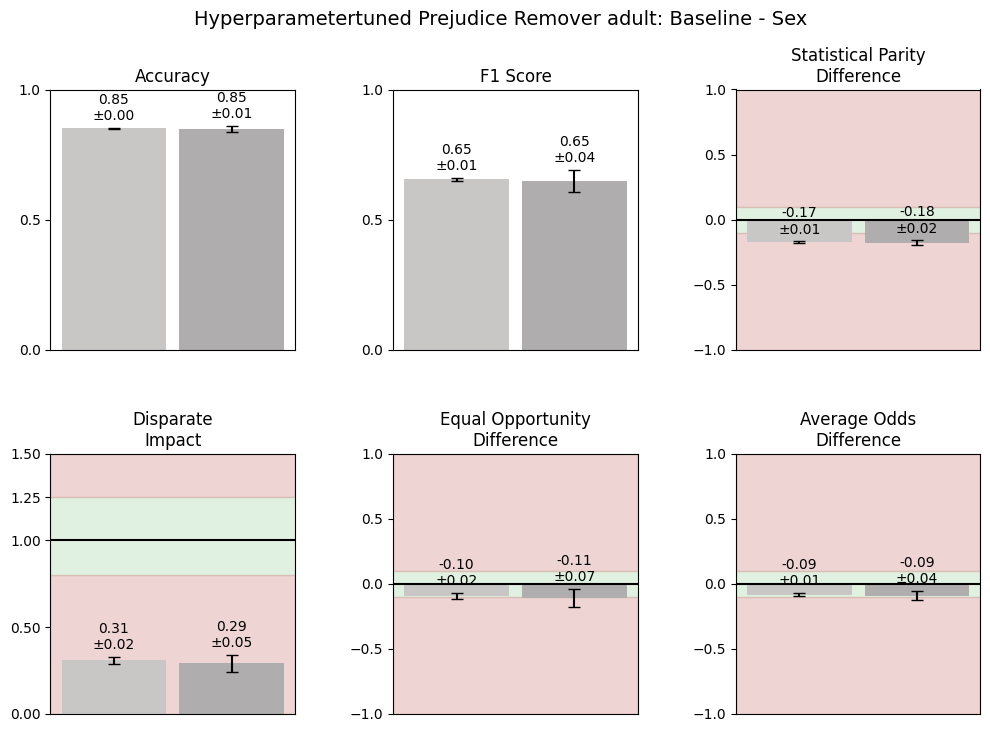

In [10]:
compare_viz_metrics_2x3(baseline_sex_agg, adult_sex_metrics_agg, 'Baseline', 'Sex', 'Hyperparametertuned Prejudice Remover adult: Baseline - Sex')